# 人脸识别



## 问题描述

  人脸识别是一个多分类问题，目的是识别输入人脸的具体身份。在实际应用中，如监控系统、社交媒体标签、访客管理等，人脸识别系统必须能够处理大量的身份，其中很多可能是训练数据集中未见过的。
  
  开集分类（Open Set Classification）是一种分类任务，其中训练数据集仅包含一部分可能出现的类别，分类器在测试时可能会遇到训练期间未见过的新类别。在这种情况下，分类器不仅需要正确识别已知类别，还需要能够识别未知类别并进行适当处理（如标记为“未知”或拒绝分类）。
  
  人脸识别是一种开集分类任务。
  

## 任务

人脸识别系统通常会采用以下策略：

- 特征提取和距离度量：使用深度学习模型提取人脸特征，将这些特征映射到一个高维特征空间中，并使用距离度量（如欧氏距离、余弦相似度等）来进行分类。
- 阈值设定：设定一个阈值来区分已知和未知类别，当距离度量低于阈值时，认为是已知类别，否则认为是未知类别。

### Siamese Network

Siamese Network（孪生网络）是一种特殊的神经网络架构，主要用于计算两个输入之间的相似性。该网络由两个或多个共享参数的子网络组成，通常用于比较两种输入数据，例如图像、文本或其他类型的数据。


<center><img src="./imgs/siamese.png" width="60%"/><center>




将Siamese Network用于人脸识别的基本原理可以分为以下几个步骤：

- 特征提取
  - 使用共享参数的卷积神经网络（CNN）从输入的两张人脸图像中提取特征。通过这种方式，每张图像被映射到一个高维特征空间中。
- 特征对比
  - 提取出的特征向量通过某种距离度量进行比较，计算两张人脸图像的相似性。常见的度量方法包括欧氏距离、余弦相似度等。
- 相似性得分
  - 网络输出一个相似性得分，表示两张人脸图像的相似程度。可以将这个得分用作阈值判断，如果相似性得分超过某个阈值，则认为两张人脸属于同一个人，否则认为是不同的人。

## 示例

### 数据准备和预处理

In [2]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [7]:
# 数据集路径
data_path = './tinyface/train'

# 读取图片和标签
def load_data(data_path):
    images = []
    labels = []
    for label in os.listdir(data_path):
        if os.path.isdir(os.path.join(data_path, label)):
            for image_name in os.listdir(os.path.join(data_path, label)):
                image_path = os.path.join(data_path, label, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Image {image_path} could not be read.")
                    continue
                image = cv2.resize(image, (100, 100))
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)


image


In [8]:
images, labels = load_data(data_path)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

# 标签编码
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# 将测试标签映射到训练标签中已知的类别
known_labels = set(le.classes_)
y_test_enc = []
for label in y_test:
    if label in known_labels:
        y_test_enc.append(le.transform([label])[0])
    else:
        y_test_enc.append(-1)
y_test_enc = np.array(y_test_enc)

# 移除测试集中未知标签的样本
known_indices = np.where(y_test_enc != -1)
x_test = x_test[known_indices]
y_test_enc = y_test_enc[known_indices]

In [13]:
# 创建Siamese网络输入对
def create_pairs(x, y):
    pairs = []
    labels = []
    n_classes = len(np.unique(y))
    class_indices = [np.where(y == i)[0] for i in range(n_classes)]

    for d in range(n_classes):
        if len(class_indices[d]) < 2:
            continue
        for i in range(len(class_indices[d]) - 1):
            z1, z2 = class_indices[d][i], class_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            labels += [1]
            inc = random.randrange(1, n_classes)
            dn = (d + inc) % n_classes
            while len(class_indices[dn]) < 1:
                inc = random.randrange(1, n_classes)
                dn = (d + inc) % n_classes
            z1, z2 = class_indices[d][i], class_indices[dn][0]
            pairs += [[x[z1], x[z2]]]
            labels += [0]
    return np.array(pairs), np.array(labels)


### 模型定义

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 128)

    def forward_one(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

def contrastive_loss(output1, output2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                  (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [15]:
train_pairs, train_labels = create_pairs(x_train, y_train_enc)
test_pairs, test_labels = create_pairs(x_test, y_test_enc)

In [16]:
# 自定义数据集类
class SiameseNetworkDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img1, img2 = self.pairs[index]
        label = self.labels[index]

        if self.transform:
            img1 = self.transform(img1.astype(np.float32))
            img2 = self.transform(img2.astype(np.float32))

        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))

    def __len__(self):
        return len(self.pairs)

In [17]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

train_dataset = SiameseNetworkDataset(train_pairs, train_labels, transform=transform)
test_dataset = SiameseNetworkDataset(test_pairs, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 训练

In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseNetwork().to(device)
criterion = contrastive_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (img1, img2, label) in  enumerate(train_loader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print(f'Batch {i+1}/{len(train_loader)} \t {loss.item():.8}', )
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Batch 1/118 	 0.49380443
Batch 2/118 	 0.39272112
Batch 3/118 	 0.38384679
Batch 4/118 	 0.31170288
Batch 5/118 	 0.32559645
Batch 6/118 	 0.32887676
Batch 7/118 	 0.30959272
Batch 8/118 	 0.33246899
Batch 9/118 	 0.40177688
Batch 10/118 	 0.28997403
Batch 11/118 	 0.28746939
Batch 12/118 	 0.33905315
Batch 13/118 	 0.38643494
Batch 14/118 	 0.32993051
Batch 15/118 	 0.34858888
Batch 16/118 	 0.29059878
Batch 17/118 	 0.54989094
Batch 18/118 	 0.31225401
Batch 19/118 	 0.45580113
Batch 20/118 	 0.34601828
Batch 21/118 	 0.31295151
Batch 22/118 	 0.46457404
Batch 23/118 	 0.3225314
Batch 24/118 	 0.39488909
Batch 25/118 	 0.33552897
Batch 26/118 	 0.33290982
Batch 27/118 	 0.31442714
Batch 28/118 	 0.34129196
Batch 29/118 	 0.28921697
Batch 30/118 	 0.36020166
Batch 31/118 	 0.33996126
Batch 32/118 	 0.40449461
Batch 33/118 	 0.32096177
Batch 34/118 	 0.34463143
Batch 35/118 	 0.31484443
Batch 36/118 	 0.3533074
Batch 37/118 	 0.35596195
Batch 38/118 	 0.33888745
Batch 39/118 	 0.323397

### 模型推理

In [19]:
def predict(image1, image2):
    image1 = cv2.resize(image1, (100, 100)) / 255.0
    image2 = cv2.resize(image2, (100, 100)) / 255.0
    image1 = torch.tensor(image1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    image2 = torch.tensor(image2, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output1, output2 = model(image1, image2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        return euclidean_distance.item()

In [20]:
image1 = x_test[0]
image2 = x_test[1]
similarity = predict(image1, image2)
print(f"Similarity score: {similarity}")

Similarity score: 0.0005751135759055614


Loading and processing images...
Processed 100 classes...
Processed 200 classes...
Processed 300 classes...
Processed 400 classes...
Processed 500 classes...
Processed 600 classes...
Processed 700 classes...
Processed 800 classes...
Processed 900 classes...
Processed 1000 classes...
Processed 1100 classes...
Processed 1200 classes...
Processed 1300 classes...
Processed 1400 classes...
Processed 1500 classes...
Processed 1600 classes...
Processed 1700 classes...
Processed 1800 classes...
Processed 1900 classes...
Processed 2000 classes...
Processed 2100 classes...
Processed 2200 classes...
Processed 2300 classes...
Processed 2400 classes...
Processed 2500 classes...
Loaded 7804 images from 2570 classes.
过滤后样本数: 4616, 类别数: 973
训练集样本数: 3643, 测试集样本数: 973
Number of classes: 973
Using device: cpu
Epoch:1 [0/3643(0%)] Loss:22.202314
Epoch:1 [3200/3643(88%)] Loss:20.893610
Train Epoch:1 AvgLoss:21.615450 Acc:1.89%
Test AvgLoss:21.796051 Acc:0.10%

Epoch:2 [0/3643(0%)] Loss:20.786903
Epoch:2 [3

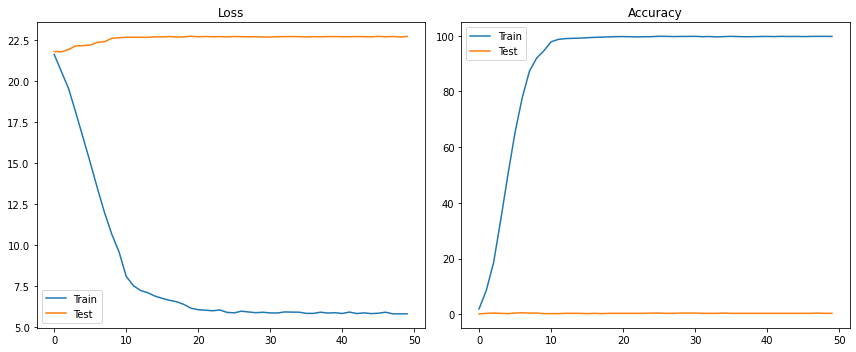

In [20]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet34
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

# ——————————————————————————————
# 超参数配置
# ——————————————————————————————
IMG_SIZE = 128       # 统一处理后图像尺寸
BATCH_SIZE = 64
EMBEDDING_SIZE = 512
MARGIN = 0.5         # ArcFace margin
SCALE = 30.0         # ArcFace scale
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# 数据存放路径
data_path = './tinyface/train'

# ——————————————————————————————
# 超分辨率函数
# ——————————————————————————————
def apply_super_resolution(image):
    """用双三次插值模拟超分辨率"""
    pil_img = Image.fromarray(image)
    sr_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)
    return np.array(sr_img)

# ——————————————————————————————
# 随机模糊增强函数
# ——————————————————————————————
def apply_random_blur(image):
    """随机应用高斯、运动或下采样模糊"""
    pil_img = Image.fromarray(image)
    blur_type = np.random.choice(['gaussian', 'motion', 'downsample'])

    if blur_type == 'gaussian':
        radius = np.random.uniform(0.5, 2.0)
        return np.array(pil_img.filter(ImageFilter.GaussianBlur(radius)))

    elif blur_type == 'motion':
        kernel_size = np.random.randint(5, 15)
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
        kernel /= kernel_size
        image_np = np.array(pil_img)
        blurred = cv2.filter2D(image_np, -1, kernel)
        return blurred

    else:  # downsample
        down_scale = np.random.uniform(0.25, 0.5)
        small_size = max(1, int(IMG_SIZE * down_scale))
        small_img = pil_img.resize((small_size, small_size), Image.BILINEAR)
        return np.array(small_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR))

# ——————————————————————————————
# 数据加载函数
# ——————————————————————————————
def load_data(data_path):
    images, labels = [], []
    print("Loading and processing images...")
    for label_idx, label in enumerate(os.listdir(data_path)):
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            continue
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Image {image_path} could not be read.")
                continue
            sr_image = apply_super_resolution(image)
            images.append(sr_image)
            labels.append(label)
        if (label_idx + 1) % 100 == 0:
            print(f"Processed {label_idx + 1} classes...")
    print(f"Loaded {len(images)} images from {len(set(labels))} classes.")
    return np.array(images), np.array(labels)

# ——————————————————————————————
# 主流程：加载数据并处理
# ——————————————————————————————
images, labels = load_data(data_path)
from collections import Counter

# 至少每个类别 3 张图片（比如训练2张，测试1张）
from collections import defaultdict
import numpy as np

# 保证每类至少有 min_images_per_class 张图像
min_images_per_class = 3
label_counts = Counter(labels)
valid_labels = {label for label, count in label_counts.items() if count >= min_images_per_class}

# 过滤数据
filtered_images = []
filtered_labels = []
for img, label in zip(images, labels):
    if label in valid_labels:
        filtered_images.append(img)
        filtered_labels.append(label)

filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)

print(f"过滤后样本数: {len(filtered_labels)}, 类别数: {len(set(filtered_labels))}")

# 手动按类划分训练/测试集
class_indices = defaultdict(list)
for idx, label in enumerate(filtered_labels):
    class_indices[label].append(idx)

x_train, y_train, x_test, y_test = [], [], [], []

for label, indices in class_indices.items():
    indices = np.array(indices)
    np.random.shuffle(indices)

    # 保证每类至少一张测试
    if len(indices) < 3:
        continue

    # 每类取前 N-1 张为训练，最后 1 张为测试（也可以自己调整）
    train_idx = indices[:-1]
    test_idx = indices[-1:]

    x_train.extend(filtered_images[train_idx])
    y_train.extend(filtered_labels[train_idx])
    x_test.extend(filtered_images[test_idx])
    y_test.extend(filtered_labels[test_idx])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"训练集样本数: {len(y_train)}, 测试集样本数: {len(y_test)}")


# 然后再做编码
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)  # 这时不会报错了

NUM_CLASSES = len(le.classes_)
print(f"Number of classes: {NUM_CLASSES}")

# ——————————————————————————————
# 自定义 Dataset
# ——————————————————————————————
class FaceDataset(Dataset):
    def __init__(self, images, labels, train=True):
        self.images = images
        self.labels = labels
        self.train = train
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        if self.train:
            img = apply_random_blur((img * 255).astype(np.uint8)) / 255.0
        img = self.transform(img).float()
        return img, torch.tensor(label, dtype=torch.long)

train_dataset = FaceDataset(x_train, y_train_enc, train=True)
test_dataset = FaceDataset(x_test, y_test_enc, train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ——————————————————————————————
# ArcFace 损失定义
# ——————————————————————————————
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=30.0):
        super().__init__()
        self.margin, self.scale = margin, scale
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)
        self.cos_m = np.cos(margin); self.sin_m = np.sin(margin)
        self.th = np.cos(np.pi - margin)
        self.mm = np.sin(np.pi - margin) * margin
    def forward(self, embeddings, labels):
        embeddings = F.normalize(embeddings)
        weight_norm = F.normalize(self.weight)
        cosine = F.linear(embeddings, weight_norm)
        sine = torch.sqrt(1.0 - cosine ** 2)
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = F.one_hot(labels, num_classes=NUM_CLASSES)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.scale
        loss = F.cross_entropy(output, labels)
        return loss

# ——————————————————————————————
# ResNet34 定义
# ——————————————————————————————
class ResNetFace(nn.Module):
    def __init__(self, embedding_size=512, num_classes=None):
        super().__init__()
        self.base = resnet34(pretrained=True)
        self.base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = nn.Identity()
        self.embedding = nn.Linear(512, embedding_size)
        self.classifier = ArcFaceLoss(embedding_size, num_classes, MARGIN, SCALE) \
                          if num_classes is not None else None
    def forward(self, x, labels=None):
        x = self.base(x)
        embeddings = self.embedding(x)
        if labels is not None and self.classifier:
            loss = self.classifier(embeddings, labels)
            return embeddings, loss
        return embeddings

# ——————————————————————————————
# 训练准备
# ——————————————————————————————
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = ResNetFace(EMBEDDING_SIZE, NUM_CLASSES).to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# ——————————————————————————————
# 训练函数
# ——————————————————————————————
def train(model, loader, optimizer, epoch):
    model.train()
    total_loss = 0.0; correct = total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        embeddings, loss = model(data, target)
        with torch.no_grad():
            logits = model.classifier.weight @ embeddings.T
            _, predicted = torch.max(logits, dim=0)
            correct += (predicted == target).sum().item()
            total += target.size(0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 50 == 0:
            print(f"Epoch:{epoch} [{batch_idx*len(data)}/{len(loader.dataset)}"
                  f"({100.*batch_idx/len(loader):.0f}%)] Loss:{loss.item():.6f}")
    avg_loss = total_loss / len(loader)
    acc = 100. * correct / total
    print(f"Train Epoch:{epoch} AvgLoss:{avg_loss:.6f} Acc:{acc:.2f}%")
    return avg_loss, acc

# ——————————————————————————————
# 测试函数
# ——————————————————————————————
def test(model, loader):
    model.eval()
    total_loss = correct = total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            embeddings, loss = model(data, target)
            total_loss += loss.item()
            logits = model.classifier.weight @ embeddings.T
            _, predicted = torch.max(logits, dim=0)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    avg_loss = total_loss / len(loader)
    acc = 100. * correct / total
    print(f"Test AvgLoss:{avg_loss:.6f} Acc:{acc:.2f}%\n")
    return avg_loss, acc

# ——————————————————————————————
# 训练主循环
# ——————————————————————————————
train_losses, train_accs = [], []
test_losses, test_accs = [], []
for epoch in range(1, NUM_EPOCHS + 1):
    tr_l, tr_a = train(model, train_loader, optimizer, epoch)
    te_l, te_a = test(model, test_loader)
    train_losses.append(tr_l); train_accs.append(tr_a)
    test_losses.append(te_l); test_accs.append(te_a)
    scheduler.step()
torch.save(model.state_dict(), "face_recognition_model.pth")
print("Model saved.")

# ——————————————————————————————
# 训练过程可视化
# ——————————————————————————————
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig('training_curve.png')
plt.show()

# ——————————————————————————————
# 相似度预测函数
# ——————————————————————————————
def predict(image1, image2):
    image1 = apply_super_resolution(image1) / 255.0
    image2 = apply_super_resolution(image2) / 255.0
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image1 = transform(image1).unsqueeze(0).to(device)
    image2 = transform(image2).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        feat1 = model(image1, labels=None)[0]
        feat2 = model(image2, labels=None)[0]
        feat1 = F.normalize(feat1)
        feat2 = F.normalize(feat2)
        return F.cosine_similarity(feat1, feat2).item()

# ——————————————————————————————
# 可视化超分辨率效果
def visualize_super_resolution(original):
    # 应用超分辨率（双三次插值模拟）
    sr = apply_super_resolution(original)

    # 创建一个图形窗口
    plt.figure(figsize=(10, 5))
    
    # 显示原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original ({original.shape[1]}x{original.shape[0]})")
    
    # 显示超分图像
    plt.subplot(1, 2, 2)
    plt.imshow(sr, cmap='gray')
    plt.title(f"Super-Resolution ({sr.shape[1]}x{sr.shape[0]})")
    
    # 保存和展示图像
    plt.savefig('super_resolution_comparison.png')
    plt.show()

